# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 1min 23s, sys: 6.09 s, total: 1min 30s
Wall time: 1min 31s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 53 s, sys: 370 ms, total: 53.3 s
Wall time: 53.4 s


In [6]:
%%time
path = os.path.join('download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariates.columns if 'acronym_' in col]
selected_cols.append('n_mutations_log1p')
covariates = covariates[selected_cols]

CPU times: user 20 ms, sys: 10 ms, total: 30 ms
Wall time: 40.9 ms


In [7]:
y = Y[GENE]

In [8]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Pre-process data set
TODO: currently running PCA on both train and test partitions

In [10]:
# Pre-process expression data for use later
n_components = 100
scaled_expression = StandardScaler().fit_transform(expression)
pca = PCA(n_components).fit(scaled_expression)
explained_variance = pca.explained_variance_
expression_pca = pca.transform(scaled_expression)
expression_pca = pd.DataFrame(expression_pca)
expression_pca = expression_pca.set_index(expression.index.values)

In [11]:
print('fraction of variance explained: ' + str(pca.explained_variance_ratio_.sum()))

fraction of variance explained: 0.704833907755


In [12]:
# Create full feature matrix (expression + covariates)
X = pd.concat([covariates,expression_pca],axis=1)
print('Gene expression matrix shape: {0[0]}, {0[1]}'.format(expression.shape))
print('Full feature matrix shape: {0[0]}, {0[1]}'.format(X.shape))

Gene expression matrix shape: 7306, 20468
Full feature matrix shape: 7306, 133


## Set aside 10% of the data for testing

In [13]:
# Typically, this can only be done where the number of mutations is large enough
train_index, test_index = next(ShuffleSplit(n_splits=2, test_size=0.1, random_state=0).split(y))

X_partitions = {
    'full': {
        'train': X.ix[train_index], 
        'test': X.ix[test_index]
        },
    'expressions': {
        'train': expression_pca.ix[train_index], 
        'test': expression_pca.ix[test_index]
        },
    'covariates': {
        'train': covariates.ix[train_index], 
        'test': covariates.ix[test_index]
        }    
    } 

y_train = y[train_index]
y_test = y[test_index]

'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(
    len(X_partitions['full']['train'].columns), 
    len(X_partitions['full']['train']), 
    len(X_partitions['full']['test']))

'Size: 133 features, 6,575 training samples, 731 testing samples'

## Define pipeline and Cross validation model fitting

In [14]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

models = ['full', 'expressions', 'covariates']

cv_pipelines = {mod: GridSearchCV(estimator=pipeline, 
                             param_grid=param_grid, 
                             n_jobs=1, 
                             scoring='roc_auc') for mod in models}

In [15]:
%%time
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    pipeline.fit(X=X_partitions.get(model).get('train'), y=y_train)
# cv_pipeline_full.fit(X=X_train_full, y=y_train)

Fitting CV for model: full
Fitting CV for model: expressions
Fitting CV for model: covariates
CPU times: user 7.15 s, sys: 15 s, total: 22.2 s
Wall time: 5.59 s


In [16]:
# Best Params
for model, pipeline in cv_pipelines.items():
    print('{0}: {1:.3%}'.format(model, pipeline.best_score_))

    # Best Params
    print(pipeline.best_params_)

full: 92.517%
{'classify__loss': 'log', 'classify__penalty': 'elasticnet', 'classify__l1_ratio': 0, 'classify__alpha': 0.1}
expressions: 91.963%
{'classify__loss': 'log', 'classify__penalty': 'elasticnet', 'classify__l1_ratio': 0, 'classify__alpha': 0.1}
covariates: 84.259%
{'classify__loss': 'log', 'classify__penalty': 'elasticnet', 'classify__l1_ratio': 0, 'classify__alpha': 0.1}


## Visualize hyperparameters performance

In [17]:
cv_results_df_dict = {model: 
    pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params']),
    ], axis='columns') for model, pipeline in cv_pipelines.items()}

model = 'full'

cv_results_df_dict[model].head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,0.034567,0.005313,0.887582,0.904469,0.001,0,log,elasticnet,"{'classify__loss': 'log', 'classify__penalty':...",11,...,0.888932,0.906338,0.003091,0.002820,0.003477,0.007088,0.001,0.0,log,elasticnet
1,0.041253,0.003162,0.904053,0.916799,0.001,0.2,log,elasticnet,"{'classify__loss': 'log', 'classify__penalty':...",8,...,0.902732,0.919364,0.002877,0.000089,0.001925,0.003983,0.001,0.2,log,elasticnet


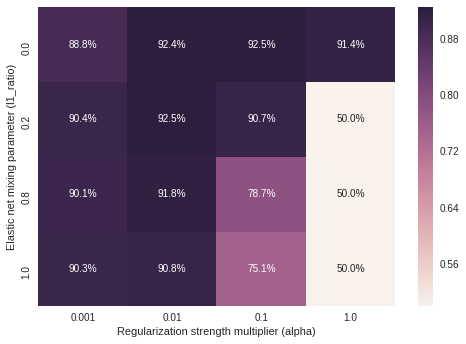

In [18]:
# Cross-validated performance heatmap
model = 'full'

cv_score_mat = pd.pivot_table(cv_results_df_dict[model],
                              values='mean_test_score', 
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [19]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_partitions[model]['train']),
        'test':  pipeline.decision_function(X_partitions[model]['test'])
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

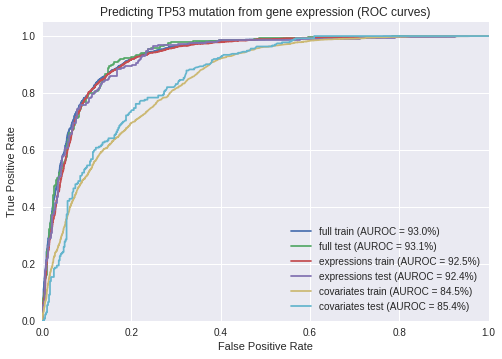

In [20]:
# TODO: replace with Vega specification
# use ipyvega?

# Plot ROC
plt.figure()
for model, metrics_partition in metrics_dict.items():
    for partition, metrics in metrics_partition.items():
        model_name = '{0} {1}'.format(model, partition)
        roc_df = metrics['roc_df']
        plt.plot(roc_df.fpr, roc_df.tpr,
            label='{} (AUROC = {:.1%})'.format(model_name, metrics['auroc']))
        
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [21]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

In [22]:
def get_coefficients(classifier, X_mat):
    coef_df = pd.DataFrame.from_items([
        ('feature', X_mat.columns),
        ('weight', classifier.coef_[0]),
    ])

    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    return coef_df

coef_df_dict = {
    model: get_coefficients(classifier, X_partitions[model]['train'])
    for model, classifier in final_classifiers.items()
}

In [23]:
model = 'full'

print('{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df_dict[model].weight == 0).mean(),
    (coef_df_dict[model].weight < 0).sum(),
    (coef_df_dict[model].weight > 0).sum()
))
coef_df_dict[model].head(10)

0.0% zero coefficients; 64 negative and 69 positive coefficients


,feature,weight,abs
35,2,-0.342498,0.342498
32,n_mutations_log1p,0.322485,0.322485
44,11,-0.276745,0.276745
57,24,0.256832,0.256832
71,38,0.248275,0.248275
62,29,0.236691,0.236691
33,0,-0.207901,0.207901
67,34,-0.207109,0.207109
64,31,-0.194507,0.194507
27,acronym_THCA,-0.193959,0.193959


## Investigate the predictions

In [24]:
model = 'full'

X_all = X_partitions[model]['train'].append(X_partitions[model]['test'])
X_test_index = X_partitions[model]['test'].index
y_all = y_train.append(y_test)

predict_df = pd.DataFrame.from_items([
    ('sample_id', X_all.index),
    ('testing', X_all.index.isin(X_test_index).astype(int)),
    ('status', y_all),
    ('decision_function', final_pipelines[model].decision_function(X_all)),
    ('probability', final_pipelines[model].predict_proba(X_all)[:, 1])
])

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [25]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,3.839451,0.978947,97.9%
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,3.523504,0.971349,97.1%
TCGA-22-4591-01,TCGA-22-4591-01,0,0,3.412372,0.968089,96.8%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,3.088669,0.956423,95.6%
TCGA-RE-A7BO-01,TCGA-RE-A7BO-01,0,0,2.792967,0.942295,94.2%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,2.603874,0.931110,93.1%
TCGA-BA-5149-01,TCGA-BA-5149-01,0,0,2.585751,0.929939,93.0%
TCGA-21-1081-01,TCGA-21-1081-01,0,0,2.539710,0.926879,92.7%
TCGA-24-2298-01,TCGA-24-2298-01,0,0,2.499669,0.924119,92.4%


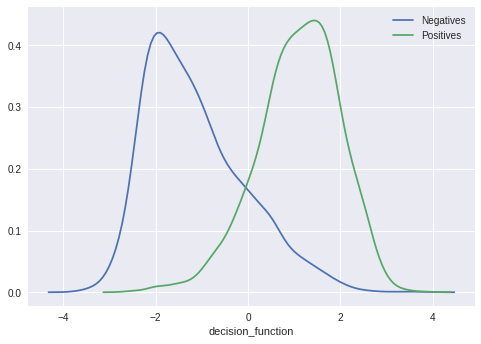

In [26]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

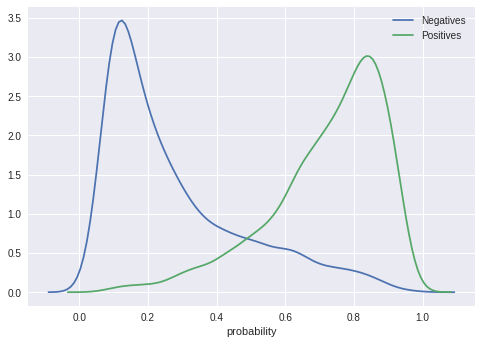

In [27]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')